In [26]:
import cv2
import os
import re
import torch
import torchvision
import numpy as np
import pandas as pd
import random
import xml.etree.ElementTree as ET
import torchvision.transforms as T
from PIL import Image
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.transform import GeneralizedRCNNTransform
from torch.utils.data import DataLoader, Dataset
from matplotlib import pyplot as plt
from matplotlib import patches
from tqdm import tqdm

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device=torch.device("cpu")
print(device)

cuda


In [28]:
# from torchvision.datasets import VOCDetection
# #downLoad Pascal VOC dataset
# VOCDetection(root='VOC_data', year='2012', image_set='trainval', download=True)

In [29]:
VOC_CLASSES_original = {
    "aeroplane": 1, "bicycle": 2, "bird": 3, "boat": 4, "bottle": 5,
    "bus": 6, "car": 7, "cat": 8, "chair": 9, "cow": 10,
    "diningtable": 11, "dog": 12, "horse": 13, "motorbike": 14, "person": 15,
    "pottedplant": 16, "sheep": 17, "sofa": 18, "train": 19, "tvmonitor": 20
}

In [30]:
# Define VOC_CLASSES for segmentation
VOC_CLASSES = {
    "bicycle": 2, "bus": 6, "car": 7, "motorbike": 14, "person": 15
}
# Re-index values
VOC_CLASSES_ReIndex = {name: idx+1 for idx, (name, _) in enumerate(VOC_CLASSES.items())}
print(VOC_CLASSES_ReIndex)

{'bicycle': 1, 'bus': 2, 'car': 3, 'motorbike': 4, 'person': 5}


In [42]:
class Config:
    learning_rate = 0.002
    momentum = 0.9
    weight_decay = 0.0005
    patience = 10
    classes = VOC_CLASSES_ReIndex

In [32]:
def get_model(num_classes):
    # Load pre-trained Faster R-CNN model with ResNet50 backbone
    model = fasterrcnn_resnet50_fpn(
        weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT,
        progress=True,
        weights_backbone=ResNet50_Weights.DEFAULT,
        trainable_backbone_layers=5
    )

    # Custom anchor generation
    anchor_sizes = ((16,), (32,), (64,), (128,), (256,))  # Custom sizes for each feature map level # check image size
    aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes) # Same aspect ratios for all levels
    anchor_generator = AnchorGenerator(
        sizes=anchor_sizes,
        aspect_ratios=aspect_ratios
    )
    model.rpn.anchor_generator = anchor_generator

    # Custom ROI Align layer
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0', '1', '2', '3'],
        output_size=7,
        sampling_ratio=2
    )
    model.roi_heads.box_roi_pool = roi_pooler

    # Replace classifier head
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [33]:
# Load the Mask R-CNN model
model = get_model(len(Config.classes)+1)
model = model.to(device)

In [34]:
# fine tunning classes
model.roi_heads.box_predictor

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=6, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=24, bias=True)
)

In [35]:
# fine tunned classes
model.roi_heads.mask_predictor

In [36]:
# transform original
model.transform

GeneralizedRCNNTransform(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    Resize(min_size=(800,), max_size=1333, mode='bilinear')
)

In [37]:
# Adjust the model transform
model.transform = GeneralizedRCNNTransform(
    min_size=400,
    max_size=600,
    image_mean=[0.485, 0.456, 0.406],
    image_std=[0.229, 0.224, 0.225],
)

In [38]:
# transform custom in model
model.transform

GeneralizedRCNNTransform(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    Resize(min_size=(400,), max_size=600, mode='bilinear')
)

In [39]:
# Custom transform to resize and normalize both image and boxes
class ResizeNormalizeTransform:
    def __init__(self, normalize = False, min_size=400, max_size=600, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):

        self.normalize = normalize # normalize in model.transform
        self.min_size = min_size
        self.max_size = max_size
        self.mean = mean
        self.std = std

    def __call__(self, image, boxes):
        # Original image size
        original_width, original_height = image.size

        # Calculate scaling factor to maintain aspect ratio
        min_original_size = float(min(original_width, original_height))
        max_original_size = float(max(original_width, original_height))

        # Calculate scale factor
        scale = self.min_size / min_original_size

        # Check if the scaling would make the longer side too big
        if scale * max_original_size > self.max_size:
            scale = self.max_size / max_original_size

        # Calculate new size
        new_width = int(original_width * scale)
        new_height = int(original_height * scale)

        # Resize image
        image = T.Resize((new_height, new_width))(image)

        # Adjust bounding boxes
        if boxes is not None and len(boxes):
            boxes = boxes.clone()
            boxes[:, [0, 2]] *= (new_width / original_width)  # Scale x coordinates
            boxes[:, [1, 3]] *= (new_height / original_height)  # Scale y coordinates

        # Convert image to tensor and normalize
        image = T.ToTensor()(image)
        if self.normalize:
            image = T.Normalize(mean=self.mean, std=self.std)(image)

        return image, boxes

# Instance transformation
transform = ResizeNormalizeTransform()


In [40]:
def plot_training_history(history):
    """Plot training and validation metrics using dictionary input"""
    plt.figure(figsize=(18, 8))

    # Plot training loss
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot mAP
    plt.subplot(2, 2, 2)
    plt.plot(history['val_map'], label='Validation mAP')
    plt.title('Validation mAP over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('mAP')
    plt.legend()
    plt.grid(True)

    # Plot Precision/Recall
    plt.subplot(2, 2, 3)
    plt.plot(history['val_precision'], label='Precision')
    plt.plot(history['val_recall'], label='Recall')
    plt.title('Precision and Recall over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)

    # Plot IoU
    plt.subplot(2, 2, 4)
    plt.plot(history['val_iou'], label='Validation IoU')
    plt.title('Validation IoU over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('training_history_Faster_RCNN.png')
    plt.show()
    plt.close()

### Load Model

In [43]:
# Prepare optimizer and scheduler
params = [param for name, param in model.named_parameters() if param.requires_grad]
optimizer = torch.optim.SGD(params, lr=Config.learning_rate, momentum=Config.momentum, weight_decay=Config.weight_decay)
#optimizer = torch.optim.Adam(params, lr=Config.learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=Config.patience)
#scheduler = get_lr_scheduler(optimizer, Config.num_epochs)
# cosine annealing scheduler
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=Config.num_epochs)


In [44]:
# Function to load the best model
def load_best_model(model, optimizer, load_path):
    if os.path.exists(load_path):
        checkpoint = torch.load(load_path, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        best_map = checkpoint['best_map']
        epoch = checkpoint['epoch']
        history = checkpoint['history']
        print(f"Loaded best model with mAP: {best_map:.4f} from epoch {checkpoint['epoch']+1}")
        return model, optimizer, best_map, epoch, history
    else:
        print("No saved model found.")
        return model, optimizer, 0.0, -1

In [45]:
# load the best model:
load_path='checkpoints/fasterRCNN/model_epoch_10_fasterRCNN.pth'
model, optimizer, best_map, epoch, history  = load_best_model(model, optimizer, load_path=load_path)

#model = torch.quantization.quantize_dynamic(model, {torch.nn.Linear}, dtype=torch.qint8) # do not work ...

model = model.to(device)


Loaded best model with mAP: 0.9159 from epoch 10


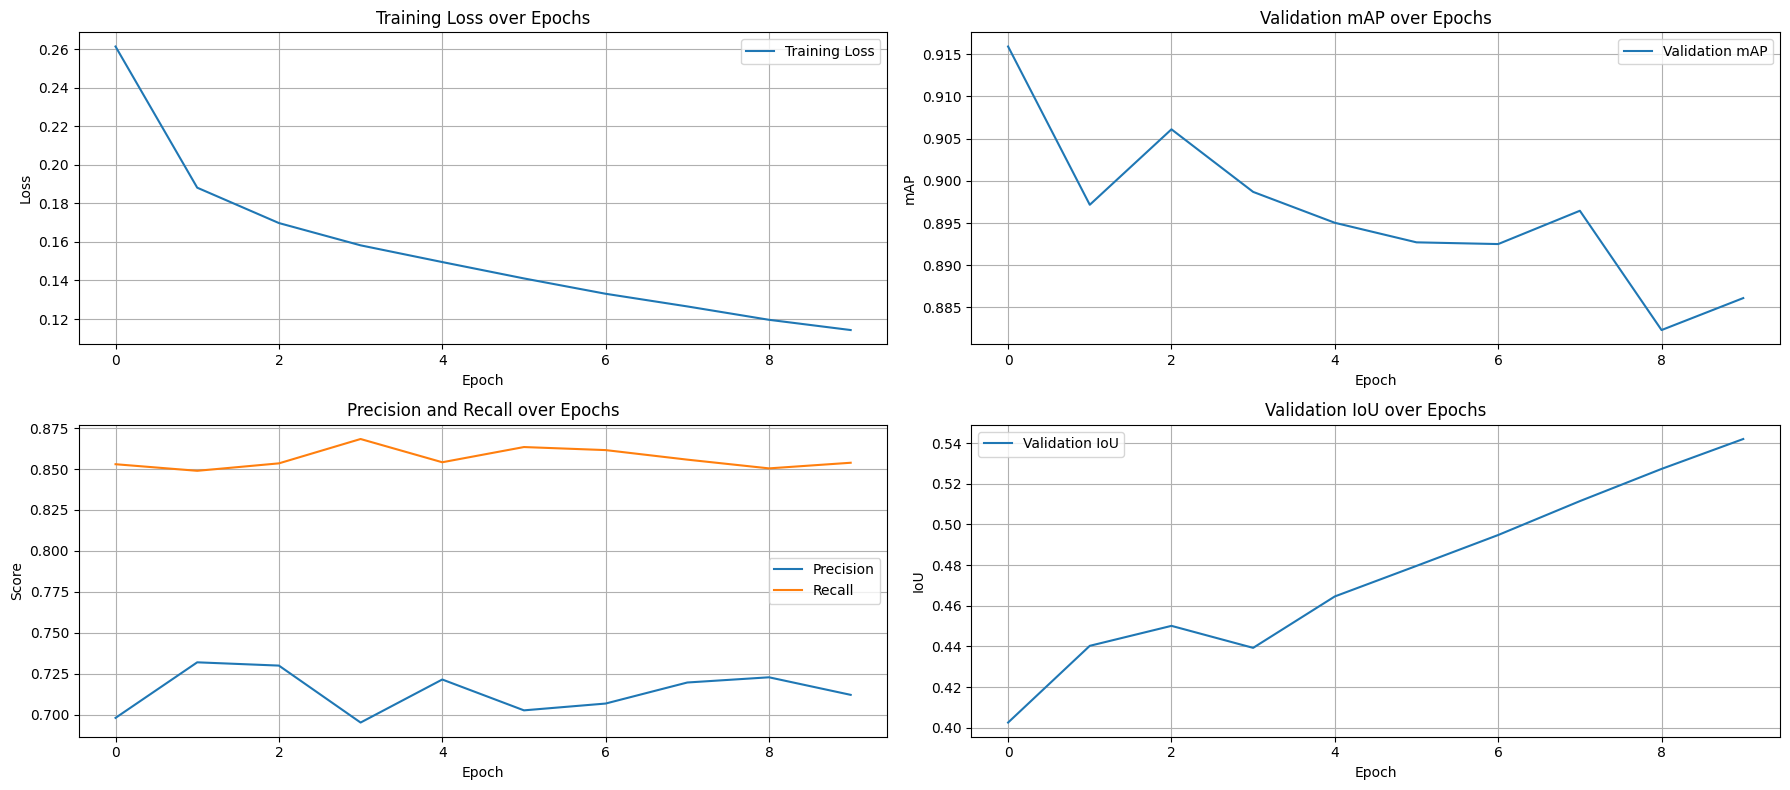

In [46]:
# Load history from checkpoint
plot_training_history(history)

In [47]:
# Get best mAP value
best_map = max(history['val_map'])

# Get epoch with best mAP
best_epoch = history['val_map'].index(best_map)

# Print best results
print(f"Best mAP: {best_map:.4f} at epoch {best_epoch + 1}")
print(f"Corresponding Precision: {history['val_precision'][best_epoch]:.4f}")
print(f"Corresponding Recall: {history['val_recall'][best_epoch]:.4f}")

Best mAP: 0.9159 at epoch 1
Corresponding Precision: 0.6981
Corresponding Recall: 0.8529


In [48]:
# VOC_CLASSES_inverted
VOC_CLASSES_inverted = {v: k for k, v in VOC_CLASSES_ReIndex.items()}
print(VOC_CLASSES_inverted)

{1: 'bicycle', 2: 'bus', 3: 'car', 4: 'motorbike', 5: 'person'}


In [50]:
# predict
def predict_image(model, image, device, confidence_threshold=0.7):

    model.eval()

    transform.normalize = False
    image, _ = transform(image, None)

    # Prepare image for model
    image = image.to(device)

    # Get predictions
    with torch.no_grad():
        predictions = model([image])

    # Get boxes, labels and scores
    boxes = predictions[0]['boxes'].cpu()
    labels = predictions[0]['labels'].cpu()
    scores = predictions[0]['scores'].cpu()

    # Filter by confidence
    mask = scores >= confidence_threshold
    boxes = boxes[mask]
    labels = labels[mask]
    scores = scores[mask]

    return image, boxes, labels, scores

In [56]:
def visualize_predictions(image, boxes, labels, scores, classes, save_path="predictions_img"):

    # Create figure and axes
    fig, ax = plt.subplots(1, figsize=(18, 12))

    img = image.detach().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    #img = ((img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]) * 255).astype(np.uint8)

    ax.imshow(img)

    classes_inverted = {v: k for k, v in classes.items()}

    # Draw each box
    for box, label, score in zip(boxes, labels, scores):
        # Convert box coordinates to integers
        box = box.numpy().astype(np.int32)

        # Create rectangle patch
        rect = patches.Rectangle(
            (box[0], box[1]),
            box[2] - box[0],
            box[3] - box[1],
            linewidth=2,
            edgecolor='r',
            facecolor='none'
        )
        ax.add_patch(rect)
        # Add label and score
        class_name = classes_inverted.get(label.item(), "Unknown") # classes start in 1, do not substract???
        ax.text(
            box[0],
            box[1] - 5,
            f'{class_name}: {score:.2f}',
            bbox=dict(facecolor='red', alpha=0.5),
            color='white'
        )

    # Remove axes
    plt.axis(False)

    # Save if path provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        plt.show()
        plt.close()
    else:
        plt.show()


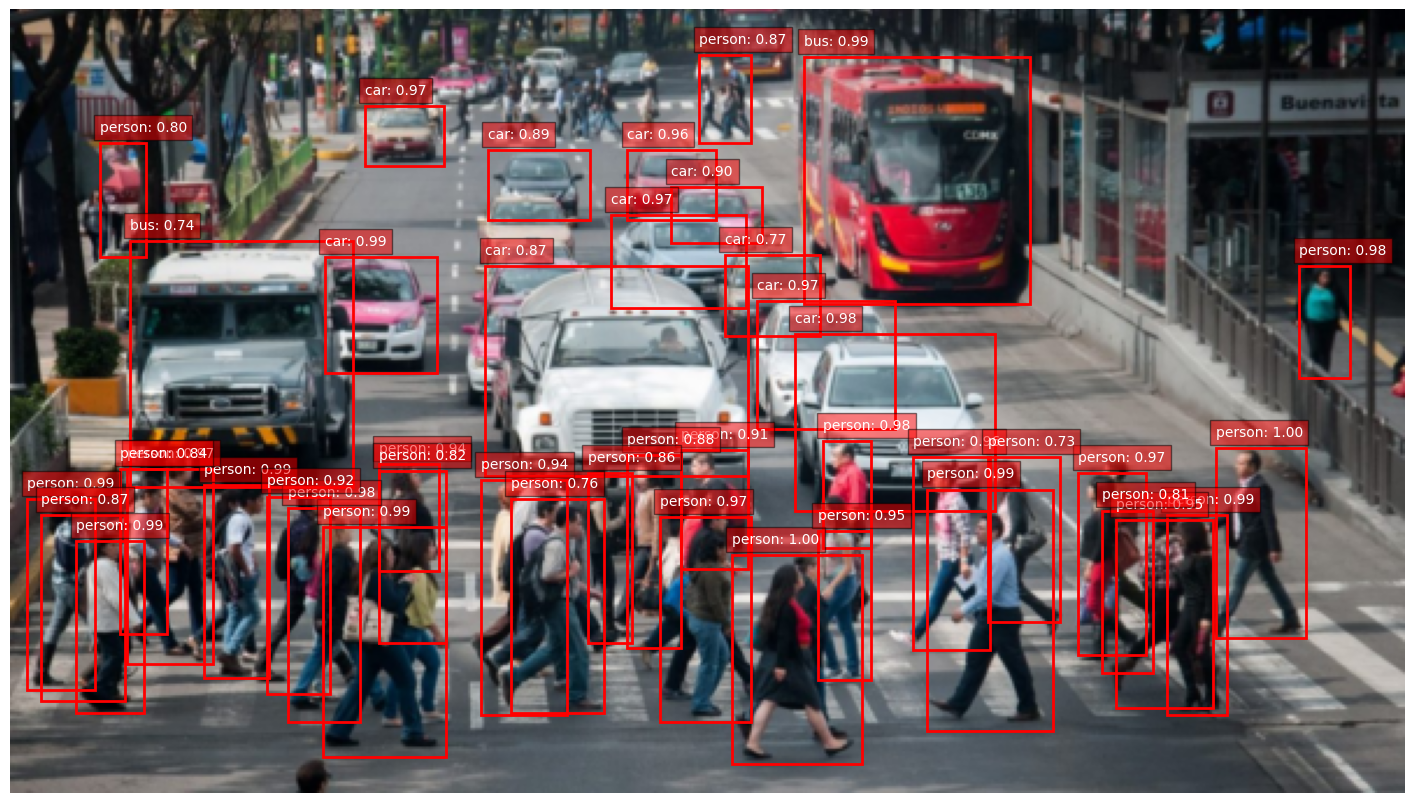

In [57]:
# Single image inference
image_path = 'img.jpg'
image_raw = Image.open(image_path).convert('RGB')

image, boxes, labels, scores = predict_image(model, image_raw, device) 
visualize_predictions(image, boxes, labels, scores, VOC_CLASSES_ReIndex)

# Batch processing
#batch_inference(model, 'test_images', 'results', VOC_CLASSES, device)

# Save results to CSV
#save_results(boxes, labels, scores, class_names, 'results.csv')

### process_video

In [60]:

def process_video(model, video_path, output_path, class_names, device, 
                 confidence_threshold=0.6, fps=6, frame_skip = 5):

    # Open video file
    cap = cv2.VideoCapture(video_path)

    # Check if the camera opened successfully
    if not cap.isOpened():
        print("Error: Could not open video stream.")
        return
        
    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Create video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    #out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))
    out = cv2.VideoWriter(output_path, fourcc, fps, (600, 400)) #resize video output

    # Counter to know how many frames you have read
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("Error: Could not read frame.")
            break
            
        if frame_count % frame_skip == 0:

            frame = cv2.resize(frame, (600, 400))
            
            # Convert BGR to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # Convert to PIL Image
            image = Image.fromarray(frame_rgb)
    
            # Get predictions
            image, boxes, labels, scores = predict_image(model, image, device, confidence_threshold)
            
            # Draw predictions on frame
            for box, label, score in zip(boxes, labels, scores):
                box = box.numpy().astype(np.int32)
                class_name = VOC_CLASSES_inverted.get(label.item(), "Unknown")
                
                # Draw box
                cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
                
                # Add label
                label_text = f'{class_name}: {score:.2f}'
                cv2.putText(frame, label_text, (box[0], box[1] - 5),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
            # Display the processed frame
            cv2.imshow('Video', frame)
            
            # Write frame
            out.write(frame)
    
            # Exit on 'q' key press
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
                
        frame_count +=1
        
    # Release everything
    cap.release()
    out.release()
    cv2.destroyAllWindows()
    

In [61]:
# Video processing
process_video(model, 'input.mp4', 'output.mp4', VOC_CLASSES_ReIndex, device)

Error: Could not read frame.


In [67]:
# Video processing
process_video(model, 0, 'output_web.mp4', VOC_CLASSES, device)